In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# LCMS Model Setup

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibrationp.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This notebook takes the prepared model calibration featureCollection assets from Module 4, downloads them, sets up LCMS models for Change, Land Cover, and Land Use using scikit-learn, evaluates them, and removes correlated predictor variables.


### Objective

In this tutorial, you learn how to download data from GEE to use be able to set up models using packages from scikit-learn 

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Bringing in annual exported training data from Module 4
- Downloading these data to a local location
- Identifying highly correlated predictor variables
- Setting up random forest models for Change, Land Cover, and Land Use and evaluating their accuracy and variable importance

In [39]:
#Module imports
#!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,seaborn

ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1234
print('Done')


Done


## Before you begin

### Set your current URL under `workbench_url`
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/`

### Set a folder to use for all exports under `export_path_root` 
* It will be something like `projects/projectID/assets/someFolder`
* This folder does not have to already exist. If it does not exist, it will be created

In [3]:
workbench_url = 'https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com'
export_path_root  = 'projects/rcr-gee/assets/lcms-training'

print('Done')

Done


In [4]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/lcms-292214/assets/R8/PR_USVI/TimeSync/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC'


# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_timeSync_folder,writers = [],all_users_can_read = True,readers = [])

print('Done')

Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Done


In [139]:
Map.proxy_url = workbench_url

# Bring in raw TS data
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
timeSync_fields = timeSyncData.first().toDictionary().keys().getInfo()
# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
# for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimsSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2020-6").first().toDictionary().getInfo()
                                             
print('LCMS class code, names, and colors:',lcms_viz_dict)


# Get the field names for prediction
# Find any field that was not in the original TimeSync data and assume that is a predictor variable
all_fields = training_data.first().toDictionary().keys().getInfo()
predictor_field_names = [field for field in all_fields if field not in timeSync_fields]

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))




LCMS class code, names, and colors: {'Change_class_names': ['Stable', 'Slow Loss', 'Fast Loss', 'Gain', 'Non-Processing Area Mask'], 'Change_class_palette': ['3d4551', 'f39268', 'd54309', '00a398', '1b1716'], 'Change_class_values': [1, 2, 3, 4, 5], 'Land_Cover_class_names': ['Trees', 'Tall Shrubs & Trees Mix (SEAK Only)', 'Shrubs & Trees Mix', 'Grass/Forb/Herb & Trees Mix', 'Barren & Trees Mix', 'Tall Shrubs (SEAK Only)', 'Shrubs', 'Grass/Forb/Herb & Shrubs Mix', 'Barren & Shrubs Mix', 'Grass/Forb/Herb', 'Barren & Grass/Forb/Herb Mix', 'Barren or Impervious', 'Snow or Ice', 'Water', 'Non-Processing Area Mask'], 'Land_Cover_class_palette': ['005e00', '008000', '00cc00', 'b3ff1a', '99ff99', 'b30088', 'e68a00', 'ffad33', 'ffe0b3', 'ffff00', 'aa7700', 'd3bf9b', 'ffffff', '4780f3', '1b1716'], 'Land_Cover_class_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Land_Use_class_names': ['Agriculture', 'Developed', 'Forest', 'Non-Forest Wetland', 'Other', 'Rangeland or Pasture', 'No

In [152]:
# Now, we'll crosswalk the training fields to numeric codes
# The TimeSync fields are a string by default
# They must be a number for modeling
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'BARREN-IMP':12,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }
# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot
                    
                    
    # print(name_fieldName,code_fieldName.getInfo(),name.getInfo(),code.getInfo())
            
# set_class_code(training_data.first(),'Land_Cover')
for product in list(reference_field_dict.keys()):
    print('Crosswalking:',product)
    training_data = training_data.map(lambda f:set_class_code(f,product))

# Take a look at the resulting cross-walked table
print('Converted codes first plot:',ee.Feature(training_data.first()).select(['CP','DOM_SEC_LC','DOM_LU','.*_Code']).toDictionary().getInfo())
print('Change class counts:',training_data.aggregate_histogram(reference_field_dict['Change']['field']).getInfo())
print('Land cover class counts:',training_data.aggregate_histogram(reference_field_dict['Land_Cover']['field']).getInfo())
print('Land use class counts:',training_data.aggregate_histogram(reference_field_dict['Land_Use']['field']).getInfo())
print('Done')

Crosswalking: Land_Cover
Crosswalking: Land_Use
Crosswalking: Change
Converted codes first plot: {'CP': 'Stable', 'CP_Code': 1, 'DOM_LU': 'Forest', 'DOM_LU_Code': 3, 'DOM_SEC_LC': 'BARREN-TRE', 'DOM_SEC_LC_Code': 5}
Change class counts: {'Debris': 6, 'Fire': 3, 'Growth/Recovery': 2501, 'Harvest': 88, 'Hydrology': 67, 'Mechanical': 197, 'Other': 10, 'Spectral Decline': 30, 'Stable': 17544, 'Structural Decline': 2, 'Wind/Ice': 543}
Land cover class counts: {'BARREN-GRA': 106, 'BARREN-IMP': 2096, 'BARREN-SHR': 108, 'BARREN-TRE': 47, 'GRASS': 2346, 'GRASS-SHRU': 877, 'GRASS-TREE': 1111, 'SHRUBS': 832, 'SHRUBS-TRE': 764, 'TREES': 12100, 'WATER': 604}
Land use class counts: {'Agriculture': 636, 'Developed': 3810, 'Forest': 11824, 'Non-forest Wetland': 999, 'Other': 815, 'Rangeland': 2907}
Done


In [183]:
# Now will download the training table to a local location

local_model_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_model_data_folder,'timeSync_training_table.csv')


if not os.path.exists(local_model_data_folder):os.makedirs(local_model_data_folder)

# Download the training data from a featureCollection to a local CSV
# This function will automatically break the featureCollection into 5000 feature featureCollections
# if it is larger than the 5000 feature limit set by GEE
g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)

# Once the table is store locally, read it in
training_df = pd.read_csv(local_training_csv)

training_df.describe()

/tmp/lcms-training/local_modeling/timeSync_training_table.csv  already exists


,BARREN,BARREN-GRA,BARREN-IMP,BARREN-SHR,BARREN-TRE,BARREN-TS,CHANGE_DUR,CP_Code,DOM_LU_Code,DOM_SEC_LC_Code,...,swir2_LT_dur,swir2_LT_fitted,swir2_LT_mag,swir2_LT_slope,wetness_LT_diff,wetness_LT_dur,wetness_LT_fitted,wetness_LT_mag,wetness_LT_slope,year
count,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,...,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000
mean,0.0,0.005050,0.099852,0.005145,0.002239,0.0,14.434424,1.446048,3.298604,4.340765,...,26.464866,0.079352,0.005295,0.000475,-0.013667,29.345386,-0.072756,-0.021041,-0.000434,2010.969020
std,0.0,0.070884,0.299810,0.071546,0.047267,0.0,6.677872,1.024257,1.289536,4.450177,...,11.170483,0.040064,0.034007,0.005681,0.029791,10.744572,0.044717,0.042725,0.005656,6.047925
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.006793,-0.210283,-0.070094,-0.483630,1.000000,-0.516985,-0.483630,-0.053737,2000.517822
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,1.000000,3.000000,1.000000,...,17.000000,0.052914,-0.011323,-0.000481,-0.025021,21.000000,-0.096717,-0.039287,-0.001377,2005.906860
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,17.000000,1.000000,3.000000,1.000000,...,28.000000,0.069325,0.006184,0.000224,-0.012569,37.000000,-0.065846,-0.021936,-0.000674,2011.208252
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,21.000000,1.000000,3.000000,9.000000,...,38.000000,0.095418,0.021533,0.000878,0.000000,38.000000,-0.044558,0.000000,0.000000,2016.167114
max,0.0,1.000000,1.000000,1.000000,1.000000,0.0,21.000000,4.000000,6.000000,14.000000,...,38.000000,0.373654,0.300531,0.204653,0.381094,38.000000,0.072465,0.381094,0.226203,2021.411011


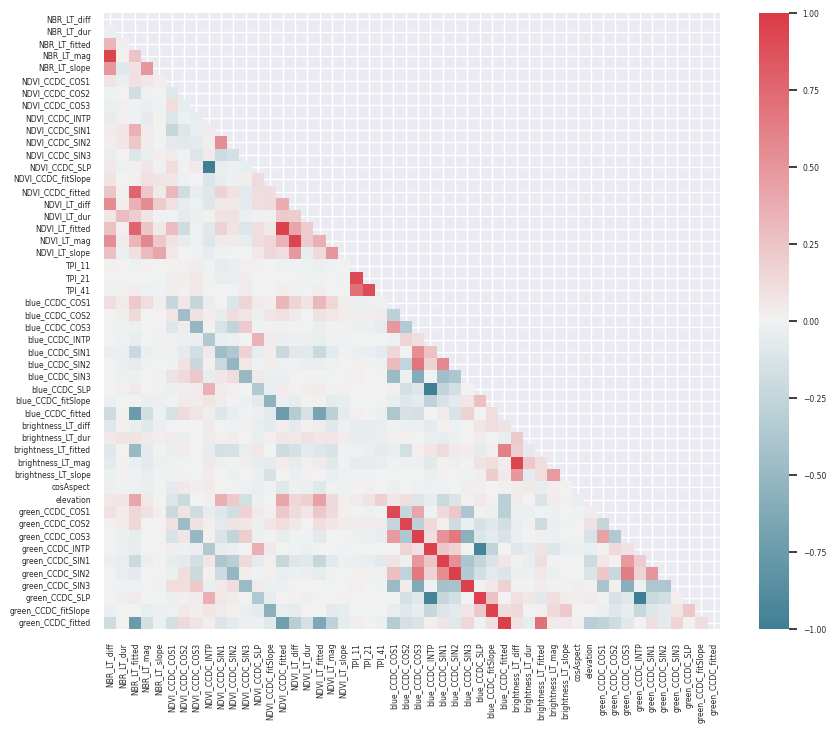

In [142]:
# Once the data are local, we can use the many packages available in Python and even R for data science
# The first step in feature selection (predictor variable selection) 
# LCMS performs is to eliminate extremely correlated predictor variables
# First, we will visualize the correlation of each pair of variables for the first 50 variables
# You can look at all variables, but it is difficult to read the variable name
# The take-home is there are some highly correlated variables that are likely not providing the model much additional information

# Get the correlation matrix for the first 50 variables
corr = training_df[predictor_field_names[:50]].corr()

# Mask out the upper right triangle and the 1:1 diagonal which always has a corr of 1
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))

# Plot the matrix
seaborn.set(font_scale=0.5)
f, ax = plt.subplots(figsize=(10, 8))
corrPlot = seaborn.heatmap(corr,
    cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

In [144]:
# In order to remove correlated variables, we will find pairs with a R2 > 0.95 and take the variable with the lowest average R2

# This is the function LCMS uses
# There are many ways of doing this, but this is a simple way that generally gives a good result
def lcms_corr_drop(x,cut = 0.95):
    # Get independent variables from training data table    
    # x = trainingData[indNames]
    indNames = x.columns
    # # reverse order of columns so that Comp features come first for each index so they will be dropped before LT features when correlated
    # x = x[x.columns[::-1]]

    # Find initial correlation of each feature to the others
    corr_matrix = x.corr().abs()
    # Calculate average correlation score of each variable
    corr_score = [corr_matrix[variable].mean() for variable in indNames]
    corr_score = zip(corr_score,indNames)
    sorted_scores = sorted(corr_score, reverse=True)
    sorted_indNames = [element for _, element in sorted_scores]

    # Redo the correlation matrix with the new order of variable names
    x = x[sorted_indNames]
    corr_matrix = x.corr().abs()
    # corr_matrix.to_csv(os.path.join(correlatedVarsDir, run_name+'_CorrelationMatrix.csv'), index = False)

    # Select lower triangle of correlation matrix
    upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)) # numpy error, np.bool is deprecated, changed to bool
    
    # This matrix is ordered in order of correlation score. Use this to check. So we drop in order of correlation score.
    # upper['Average_Scores'] = [pd.concat([upper[varName],upper.loc[varName].transpose()]).mean(skipna=True) for varName in upper.columns]

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cut)]
    return to_drop

print('Done')

Done


In [184]:
# Find correlated variables to drop and remove them from the predictor field name list
lcms_to_drop = lcms_corr_drop(training_df[predictor_field_names],cut = 0.95)
print('Correlated variables:',lcms_to_drop)

predictor_field_names_no_corr = [var for var in predictor_field_names if var not in lcms_to_drop]

# Save predictor variables for use in next notebook
all_predictors_csv = os.path.join(local_model_data_folder,'all_predictor_field_names.csv')
o = open(all_predictors_csv,'w')
o.write(','.join(predictor_field_names))
o.close()

no_corr_predictors_csv = os.path.join(local_model_data_folder,'no_corr_predictor_field_names.csv')
o = open(no_corr_predictors_csv,'w')
o.write(','.join(predictor_field_names_no_corr))
o.close()

print('Done')

Correlated variables: ['red_CCDC_fitted', 'green_CCDC_fitted', 'NDVI_CCDC_fitted', 'blue_CCDC_SIN1', 'green_CCDC_COS3', 'red_CCDC_INTP', 'blue_CCDC_SIN2', 'green_CCDC_INTP', 'green_CCDC_SLP', 'blue_CCDC_INTP', 'swir1_CCDC_SLP', 'swir2_CCDC_SLP', 'green_CCDC_SIN3', 'NDVI_CCDC_SLP', 'green_CCDC_fitSlope', 'nir_CCDC_SLP']
Done


In [168]:
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,balanced_accuracy_score,cohen_kappa_score

# Now we will fit RF models and evaluate them using several methods
# This will help us understand the error structure within the model

# Specify the number of trees and a random seed
# Ideally the number of trees is around 150-250 or so, but it will take a long
# time to run the analysis when it's at 150 or so. 50 is generally enough to get a sense of model accuraccy
nTrees = 5
seed = 999

def fit_rf(product_name,predictor_fields,title_prefix='',var_importance_n = 50):
    product_title = product_name.replace('_',' ')
    
    # Pull out the dependent (y) and independent predictors (X)
    X = training_df[predictor_fields]
    y = training_df[reference_field_dict[product_name]['field']+'_Code']
    
    # Split them into a test and train set for further model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Set up a random forest model
    rf = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
    
    # First, fit it using all training data
    rf.fit(X,y)
    
    # Get the out-of-bag accuracy 
    # This is generally a good indication of model accuracy
    oob_acc = rf.oob_score_
    print(f'{title_prefix} {product_title} out-of-bag accuracy:',"%.4f" % oob_acc)
    
    # Now let's look at the variable importance
    feature_importances = pd.Series(rf.feature_importances_, index=predictor_fields).sort_values(ascending=True)
    feature_importances.iloc[-var_importance_n:].plot.barh(fontsize=5,title=f'{title_prefix} {product_title} Variable Importance')
    plt.show()
 
    # Now, fit the model using the 80% training subset
    rf.fit(X_train,y_train)
    
    # And then apply it to the 20% test subset
    y_pred = rf.predict(X_test)

    # Find the class names
    class_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    
    # Remove the missing classes in PRUSVI
    if product_name == 'Land_Cover':
        del class_names[1]
        del class_names[4]
        del class_names[-2]
    
    # Get various accuracy metrics
    overall_acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Print info about the model
    print(f'{title_prefix} {product_title} report:')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    print(f'{title_prefix} {product_title} Overall Accuracy:',"%.4f" % overall_acc)
    print(f'{title_prefix} {product_title} Balanced Accuracy:',"%.4f" % balanced_acc)
    print(f'{title_prefix} {product_title} Kappa:',"%.4f" % kappa)
    
    predictors_by_importance = feature_importances.index.tolist()
    predictors_by_importance.reverse()
    return oob_acc,overall_acc,balanced_acc,kappa,predictors_by_importance
print('Done')

Done


All Predictors Change out-of-bag accuracy: 0.9190


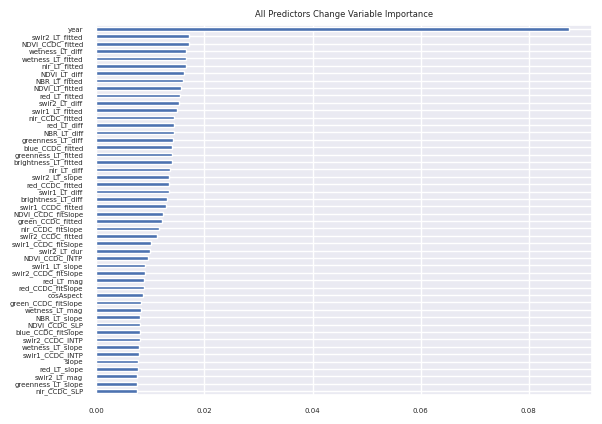

All Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.9367    0.9783    0.9570      3496
   Slow Loss     0.2222    0.5000    0.3077         4
   Fast Loss     0.5441    0.1859    0.2772       199
        Gain     0.7389    0.6960    0.7168       500

    accuracy                         0.9066      4199
   macro avg     0.6105    0.5900    0.5647      4199
weighted avg     0.8939    0.9066    0.8956      4199

All Predictors Change Overall Accuracy: 0.9066
All Predictors Change Balanced Accuracy: 0.5900
All Predictors Change Kappa: 0.6436
Non-correlated Predictors Change out-of-bag accuracy: 0.9192


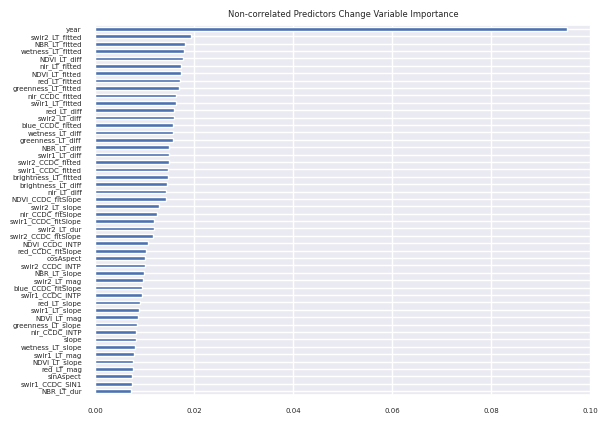

Non-correlated Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.9352    0.9817    0.9579      3498
   Slow Loss     0.3750    0.6000    0.4615         5
   Fast Loss     0.5556    0.1905    0.2837       210
        Gain     0.7718    0.7099    0.7395       486

    accuracy                         0.9102      4199
   macro avg     0.6594    0.6205    0.6107      4199
weighted avg     0.8966    0.9102    0.8983      4199

Non-correlated Predictors Change Overall Accuracy: 0.9102
Non-correlated Predictors Change Balanced Accuracy: 0.6205
Non-correlated Predictors Change Kappa: 0.6524
Top 30 Var Imp Change out-of-bag accuracy: 0.9200


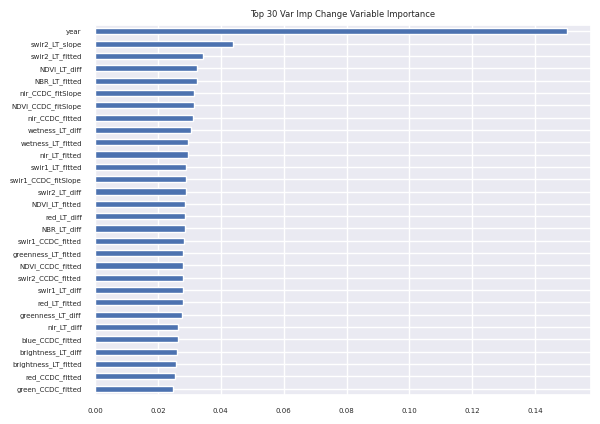

Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.9292    0.9883    0.9579      3518
   Slow Loss     1.0000    0.5000    0.6667         6
   Fast Loss     0.7767    0.4762    0.5904       168
        Gain     0.8860    0.6134    0.7249       507

    accuracy                         0.9219      4199
   macro avg     0.8980    0.6445    0.7350      4199
weighted avg     0.9180    0.9219    0.9146      4199

Top 30 Var Imp Change Overall Accuracy: 0.9219
Top 30 Var Imp Change Balanced Accuracy: 0.6445
Top 30 Var Imp Change Kappa: 0.6776
Non Corr Top 30 Var Imp Change out-of-bag accuracy: 0.9265


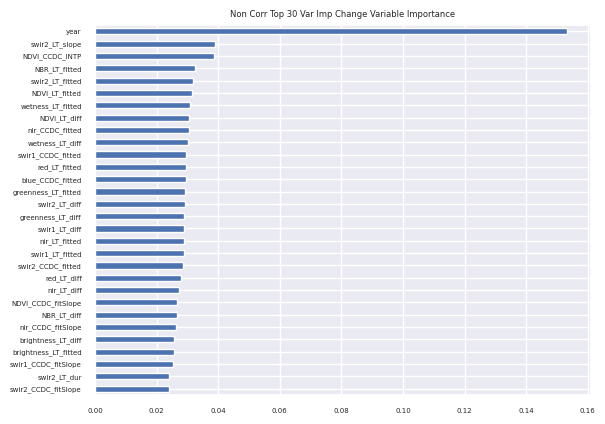

Non Corr Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.9300    0.9867    0.9575      3527
   Slow Loss     0.0000    0.0000    0.0000         1
   Fast Loss     0.7373    0.4754    0.5781       183
        Gain     0.8817    0.6107    0.7215       488

    accuracy                         0.9205      4199
   macro avg     0.6372    0.5182    0.5643      4199
weighted avg     0.9157    0.9205    0.9133      4199

Non Corr Top 30 Var Imp Change Overall Accuracy: 0.9205
Non Corr Top 30 Var Imp Change Balanced Accuracy: 0.5182
Non Corr Top 30 Var Imp Change Kappa: 0.6698
All Predictors Land Cover out-of-bag accuracy: 0.9765


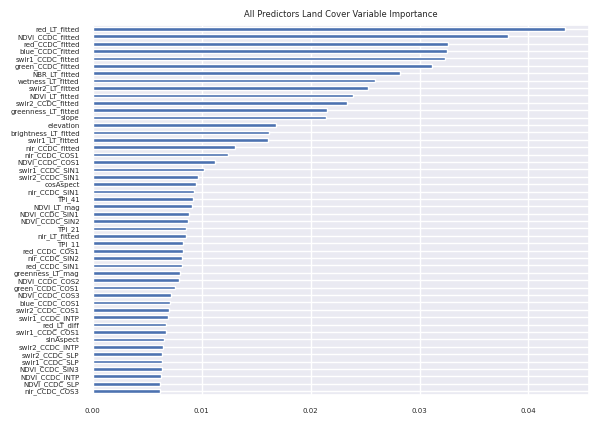

All Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9888    0.9925    0.9907      2410
          Shrubs & Trees Mix     0.9225    0.8851    0.9034       148
 Grass/Forb/Herb & Trees Mix     0.9353    0.9394    0.9374       231
          Barren & Trees Mix     0.6000    0.7500    0.6667         8
                      Shrubs     0.9557    0.9264    0.9408       163
Grass/Forb/Herb & Shrubs Mix     0.9235    0.9337    0.9286       181
         Barren & Shrubs Mix     0.9000    0.7826    0.8372        23
             Grass/Forb/Herb     0.9721    0.9609    0.9665       435
Barren & Grass/Forb/Herb Mix     0.8000    0.7059    0.7500        17
        Barren or Impervious     0.9808    0.9935    0.9871       463
                       Water     0.9835    0.9917    0.9876       120

                    accuracy                         0.9748      4199
                   macro avg     0.9057    0.8965    0

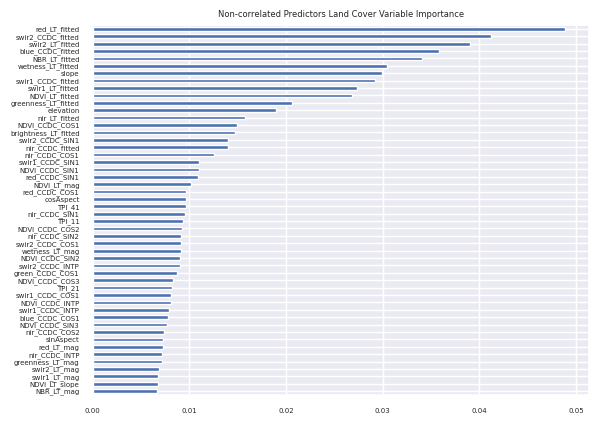

Non-correlated Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9847    0.9927    0.9886      2456
          Shrubs & Trees Mix     0.9127    0.8394    0.8745       137
 Grass/Forb/Herb & Trees Mix     0.9293    0.8932    0.9109       206
          Barren & Trees Mix     0.3333    0.1667    0.2222         6
                      Shrubs     0.9835    0.9835    0.9835       182
Grass/Forb/Herb & Shrubs Mix     0.9363    0.9074    0.9216       162
         Barren & Shrubs Mix     0.9167    0.9565    0.9362        23
             Grass/Forb/Herb     0.9573    0.9682    0.9627       440
Barren & Grass/Forb/Herb Mix     0.8261    0.7600    0.7917        25
        Barren or Impervious     0.9778    0.9821    0.9800       448
                       Water     0.9826    0.9912    0.9869       114

                    accuracy                         0.9726      4199
                   macro avg     0.8855    

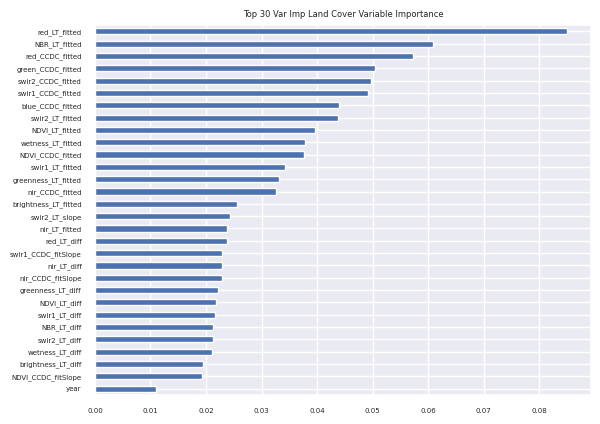

Top 30 Var Imp Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9537    0.9937    0.9733      2382
          Shrubs & Trees Mix     0.9316    0.7267    0.8165       150
 Grass/Forb/Herb & Trees Mix     0.9198    0.8025    0.8571       243
          Barren & Trees Mix     0.5000    0.2500    0.3333        12
                      Shrubs     0.9524    0.8537    0.9003       164
Grass/Forb/Herb & Shrubs Mix     0.9724    0.8393    0.9010       168
         Barren & Shrubs Mix     0.9231    0.8571    0.8889        28
             Grass/Forb/Herb     0.9376    0.9535    0.9455       473
Barren & Grass/Forb/Herb Mix     0.8333    0.6522    0.7317        23
        Barren or Impervious     0.9602    0.9864    0.9731       440
                       Water     0.9912    0.9655    0.9782       116

                    accuracy                         0.9505      4199
                   macro avg     0.8978    0.8073    0

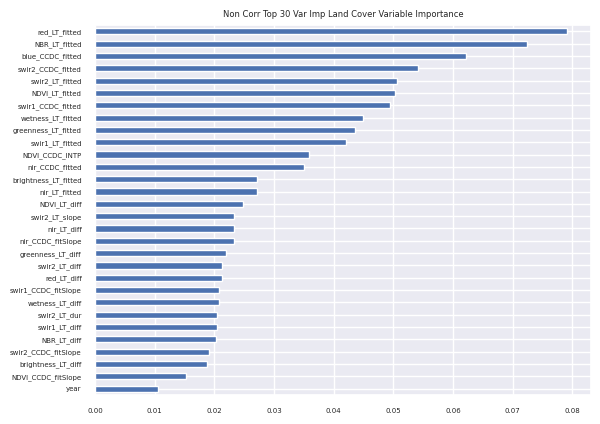

Non Corr Top 30 Var Imp Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9715    0.9934    0.9823      2433
          Shrubs & Trees Mix     0.9194    0.8321    0.8736       137
 Grass/Forb/Herb & Trees Mix     0.9296    0.8726    0.9002       212
          Barren & Trees Mix     0.6000    0.3000    0.4000        10
                      Shrubs     0.9627    0.9226    0.9422       168
Grass/Forb/Herb & Shrubs Mix     0.9721    0.8406    0.9016       207
         Barren & Shrubs Mix     0.9048    0.8636    0.8837        22
             Grass/Forb/Herb     0.9514    0.9595    0.9554       469
Barren & Grass/Forb/Herb Mix     1.0000    0.5652    0.7222        23
        Barren or Impervious     0.9529    0.9878    0.9701       410
                       Water     0.9730    1.0000    0.9863       108

                    accuracy                         0.9628      4199
                   macro avg     0.9216    0.

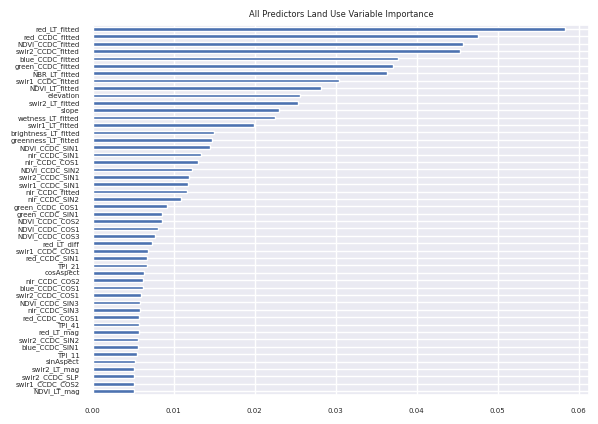

All Predictors Land Use report:
                      precision    recall  f1-score   support

         Agriculture     1.0000    0.9840    0.9919       125
           Developed     0.9947    0.9960    0.9953       748
              Forest     0.9962    0.9975    0.9968      2369
  Non-Forest Wetland     1.0000    0.9953    0.9976       213
               Other     0.9935    0.9871    0.9903       155
Rangeland or Pasture     0.9915    0.9915    0.9915       589

            accuracy                         0.9955      4199
           macro avg     0.9960    0.9919    0.9939      4199
        weighted avg     0.9955    0.9955    0.9955      4199

All Predictors Land Use Overall Accuracy: 0.9955
All Predictors Land Use Balanced Accuracy: 0.9919
All Predictors Land Use Kappa: 0.9928
Non-correlated Predictors Land Use out-of-bag accuracy: 0.9951


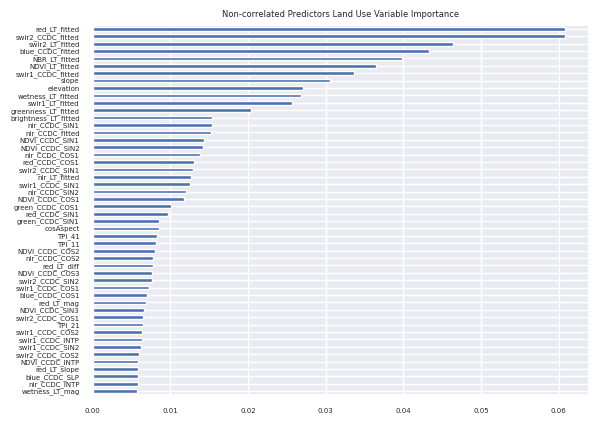

Non-correlated Predictors Land Use report:
                      precision    recall  f1-score   support

         Agriculture     1.0000    0.9931    0.9965       144
           Developed     0.9892    1.0000    0.9946       733
              Forest     0.9979    0.9971    0.9975      2380
  Non-Forest Wetland     0.9951    0.9951    0.9951       205
               Other     1.0000    0.9940    0.9970       168
Rangeland or Pasture     0.9912    0.9842    0.9877       569

            accuracy                         0.9955      4199
           macro avg     0.9956    0.9939    0.9947      4199
        weighted avg     0.9955    0.9955    0.9955      4199

Non-correlated Predictors Land Use Overall Accuracy: 0.9955
Non-correlated Predictors Land Use Balanced Accuracy: 0.9939
Non-correlated Predictors Land Use Kappa: 0.9928
Top 30 Var Imp Land Use out-of-bag accuracy: 0.9788


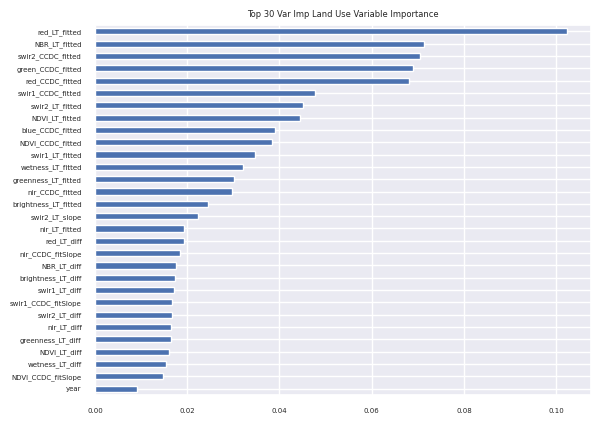

Top 30 Var Imp Land Use report:
                      precision    recall  f1-score   support

         Agriculture     1.0000    0.9580    0.9785       119
           Developed     0.9830    0.9843    0.9836       764
              Forest     0.9833    0.9983    0.9907      2356
  Non-Forest Wetland     0.9951    0.9231    0.9577       221
               Other     1.0000    0.9938    0.9969       160
Rangeland or Pasture     0.9858    0.9603    0.9729       579

            accuracy                         0.9852      4199
           macro avg     0.9912    0.9696    0.9801      4199
        weighted avg     0.9853    0.9852    0.9851      4199

Top 30 Var Imp Land Use Overall Accuracy: 0.9852
Top 30 Var Imp Land Use Balanced Accuracy: 0.9696
Top 30 Var Imp Land Use Kappa: 0.9763
Non Corr Top 30 Var Imp Land Use out-of-bag accuracy: 0.9826


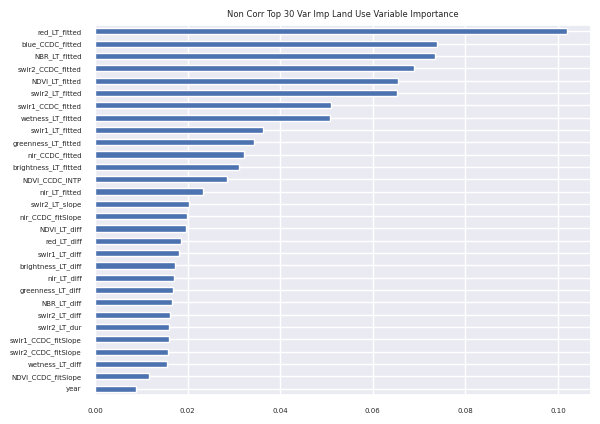

Non Corr Top 30 Var Imp Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.9845    0.9407    0.9621       135
           Developed     0.9789    0.9949    0.9868       791
              Forest     0.9775    0.9970    0.9871      2305
  Non-Forest Wetland     1.0000    0.9278    0.9626       194
               Other     0.9940    0.9651    0.9794       172
Rangeland or Pasture     0.9859    0.9302    0.9573       602

            accuracy                         0.9807      4199
           macro avg     0.9868    0.9593    0.9725      4199
        weighted avg     0.9809    0.9807    0.9805      4199

Non Corr Top 30 Var Imp Land Use Overall Accuracy: 0.9807
Non Corr Top 30 Var Imp Land Use Balanced Accuracy: 0.9593
Non Corr Top 30 Var Imp Land Use Kappa: 0.9695
Done


In [148]:
# Now evaluate models for each LCMS product with various sets of predictor variables
# and create a summary table
product_names = ['Change','Land_Cover','Land_Use']
acc_table = []
for product_name in product_names:
    
    # First fit a model using all predictors
    all_model_info = list(fit_rf(product_name,predictor_field_names,'All Predictors'))
    all_model_info.insert(0,'All Predictors')
    all_model_info.insert(0,product_name)
    acc_table.append(all_model_info)
    
    # Then fit a model using the variables with < 0.95 r-squared
    non_corr_model_info = list(fit_rf(product_name,predictor_field_names_no_corr,'Non-correlated Predictors'))
    non_corr_model_info.insert(0,'Non-correlated Predictors')
    non_corr_model_info.insert(0,product_name)
    acc_table.append(non_corr_model_info)
    
    # Next take only the top 30 predictors regardless of co-variance 
    all_top30_model_info = list(fit_rf(product_name,all_var_imp[:30],'Top 30 Var Imp'))
    all_top30_model_info.insert(0,'All Predictors Top 30')
    all_top30_model_info.insert(0,product_name)
    acc_table.append(all_top30_model_info)
    
    # Then take the top 30 with < 0.95 r-squared
    non_corr_top30_model_info = list(fit_rf(product_name,non_corr_var_imp[:30],'Non Corr Top 30 Var Imp'))
    non_corr_top30_model_info.insert(0,'Non-correlated Predictors Top 30')
    non_corr_top30_model_info.insert(0,product_name)
    acc_table.append(non_corr_top30_model_info)

print('Done')

In [188]:
model_options_df = pd.DataFrame(acc_table,columns = ['Product Name','Model Name','OOB Acc','Overall Acc','Balanced Acc','Kappa','Var Imp'])
display(model_options_df)

# Save table for use in notebook 5.2
model_options_csv_filename = os.path.join(local_model_data_folder,'LCMS_model_options_table.csv')
model_options_df.to_csv(model_options_csv_filename,index=False)
    
print('Done')

,Product Name,Model Name,OOB Acc,Overall Acc,Balanced Acc,Kappa,Var Imp
0,Change,All Predictors,0.918965,0.906644,0.590048,0.643616,"[year, swir2_LT_fitted, NDVI_CCDC_fitted, wetn..."
1,Change,Non-correlated Predictors,0.919156,0.910217,0.620514,0.652430,"[year, swir2_LT_fitted, NBR_LT_fitted, wetness..."
2,Change,All Predictors Top 30,0.919966,0.921886,0.644487,0.677602,"[year, swir2_LT_slope, swir2_LT_fitted, NDVI_L..."
3,Change,Non-correlated Predictors Top 30,0.926492,0.920457,0.518185,0.669777,"[year, swir2_LT_slope, NDVI_CCDC_INTP, NBR_LT_..."
4,Land_Cover,All Predictors,0.976466,0.974756,0.896522,0.960432,"[red_LT_fitted, NDVI_CCDC_fitted, red_CCDC_fit..."
5,Land_Cover,Non-correlated Predictors,0.975323,0.972613,0.858269,0.956190,"[red_LT_fitted, swir2_CCDC_fitted, swir2_LT_fi..."
6,Land_Cover,All Predictors Top 30,0.960030,0.950464,0.807315,0.921748,"[red_LT_fitted, NBR_LT_fitted, red_CCDC_fitted..."
7,Land_Cover,Non-correlated Predictors Top 30,0.962174,0.962848,0.830684,0.940699,"[red_LT_fitted, NBR_LT_fitted, blue_CCDC_fitte..."
8,Land_Use,All Predictors,0.994903,0.995475,0.991895,0.992761,"[red_LT_fitted, red_CCDC_fitted, NDVI_CCDC_fit..."
9,Land_Use,Non-correlated Predictors,0.995141,0.995475,0.993911,0.992758,"[red_LT_fitted, swir2_CCDC_fitted, swir2_LT_fi..."


Done


In [187]:
os.listdir(local_model_data_folder)

['no_corr_predictor_field_names.csv',
 'all_predictor_field_names.csv',
 'timeSync_training_table.csv',
 'LCMS_model_options_table.csv']

Getting model info for All Predictors Change
All Predictors Change OOB Accuracy: 0.9221094754894955


,Stable,Slow Loss,Fast Loss,Gain,Producers Accuracy (1 - omission error)
Stable,17542,0,0,2,99
Slow Loss,1,31,0,0,96
Fast Loss,57,0,852,5,93
Gain,20,0,0,2481,99
Consumers Accuracy (1 - commission error),99,100,100,99,99


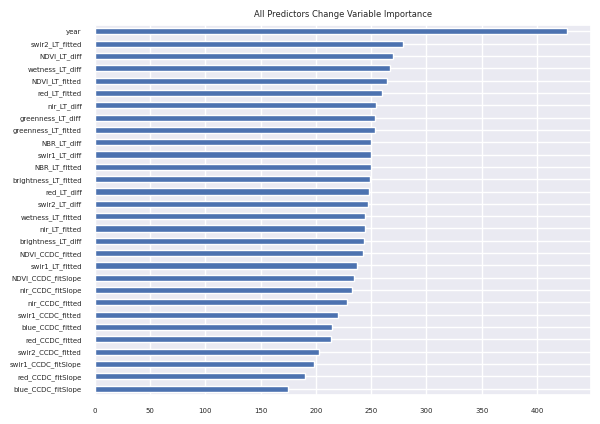

AttributeError: 'FeatureCollection' object has no attribute 'confusionMatrix'

In [179]:

# Not let's train similar models inside GEE to see the similarities and differences

# Set some parameters
top_n_variables = 30 # Take this number of variables into the final model
nTrees = 50

# Function to take GEE variable importance and make a pyplot barchart
def var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = 30,descending = True):
    feature_importances = pd.Series(importance_dict.values(), index=importance_dict.keys())\
                            .sort_values(ascending=descending)\
                            .iloc[-n_variables:]
    feature_importances.plot.barh(title=title,fontsize=5);
    plt.show()
# Function to take GEE confusionMatrix object and make a Pandas dataframe from it
def formatConfusionMatrix(confusionMatrix,code_names):
    # Only make one call to GEE for the confusion matrix info
    cm_info = ee.Dictionary({
        'accuracy':confusionMatrix.accuracy(),
        'consumersAccuracy':confusionMatrix.consumersAccuracy(),
        'producersAccuracy':confusionMatrix.producersAccuracy(),
        'confusionMatrix':confusionMatrix
    }).getInfo()
    
    # Pull the overall accuracy (this is not from the out-of-bag samples, os is higher than the OOB accuracy
    overall_accuracy = int(cm_info['accuracy']*100)
    
    # Get the consumers accuracy and get rid of the 0 value (1 - commission error)
    consumers_accuracy = [int(i*100) for i in cm_info['consumersAccuracy'][0][1:]]
    consumers_accuracy.append(overall_accuracy)
    
    # Get the producers accuracy and get rid of the 0 value (1 - omission error)
    producers_accuracy = [int(i[0]*100) for i in cm_info['producersAccuracy'][1:]]
    
    # Pull in the confusion matrix (this uses all samples, so it is far more accurate than reality)
    confusionMatrix = cm_info['confusionMatrix']
    
    # Get rid of 0 value row and column (0 is not used for any LCMS output value)
    confusionMatrix = [row[1:] for row in confusionMatrix[1:]]
    
    # Append the producers and consumers accuracy
    confusionMatrix2 = []
    for i,row in enumerate(confusionMatrix):
        row.append(producers_accuracy[i])
        confusionMatrix2.append(row)
    confusionMatrix2.append(consumers_accuracy)
    
    # Give meaningful row and column names
    row_names = code_names.copy()
    col_names = code_names.copy()
    row_names.append('Consumers Accuracy (1 - commission error)')
    col_names.append('Producers Accuracy (1 - omission error)')
    
    # Show the confusion matrix
    display(pd.DataFrame(confusionMatrix2 ,index = row_names,columns = col_names))
    
# Function to get info from a GEE random forest model
def getModelInfo(model, code_names,title = ''):
    print('Getting model info for',title)
    
    
    importance = model.explain().get('importance').getInfo()
    OOB_accuraccy = 1- model.explain().get('outOfBagErrorEstimate').getInfo()
    
    print(f'{title} OOB Accuracy: {OOB_accuraccy}')
    confusionMatrix = model.confusionMatrix()
    formatConfusionMatrix(confusionMatrix,code_names)
    
    # Get the variable importance plot
    return var_importance_plot(importance,title + ' Variable Importance')
    
rf_models = {}
def fit_rf(product_name):
    product_title = product_name.replace('_',' ')
    # Set up RF model 
    rf = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

    # Fit the RF model using all predictors
    rf = rf.train(training_data, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    rf_models[product_name] = rf
    # Get model info
    code_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    importance = getModelInfo(rf, code_names,f'All Predictors {product_title}')
    
    

    training = training_data.filter("random < 0.8")
    holdout = training_data.filter("random >= 0.8")
    rf2 = rf.train(training, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    validation = holdout.classify(rf2,'predicted')
    # # print(validation.first().getInfo())
    confusionMatrix = validation.confusionMatrix(reference_field_dict[product_name]['field']+'_Code', "predicted")
    formatConfusionMatrix(confusionMatrix,code_names)
    # print(errorMatrix.getInfo())

    
    # predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)

    # Map.addLayer(predicted,{'autoViz':True},f'All Predictors {product_title} {apply_year}')
training_data = training_data.randomColumn(seed=seed)
for product in ['Land_Cover','Land_Use','Change'][-1:]:
    fit_rf(product)
# print(training_data.size().getInfo())
# Notice the out-of-bag accuracy is roughly the same as in scikit-learn random forest

# # importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
# rf_lc = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# lc_predictor_field_names =  list(importance.keys())
# rf_lc = rf_lc.train(training_data, reference_field_dict['Land_Cover']['field']+'_Code',lc_predictor_field_names)#['NBR_LT_fitted'])
# # importance = rf_lc.explain().get('importance').getInfo()
# getModelInfo(rf_lc, lcms_viz_dict['Land_Cover_class_names'][:-1],f'Top {top_n_variables} Variables Land Cover')
# # var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


# lc_predicted = predictor_stack.classify(rf_lc,'Land_Cover').set(lcms_viz_dict)
# # # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lc_predicted,{'autoViz':True},f'Land Cover Top {top_n_variables}')
# Map.turnOnInspector()
# Map.view()

# Notice that there is quite a bit omission error in fast loss even for the training samples. 
# This means the omission error is likely much higher in reality

In [64]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=10,scoring = 'balanced_accuracy')
scores
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

NameError: name 'rf' is not defined